In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

def MAE(y_true,y_pred):
    return round(mean_absolute_error(y_true,y_pred),2)

def W_SMAPE(y_true, y_pred):
    if not isinstance(y_true,np.ndarray):y_true = y_true.to_numpy()
    if not isinstance(y_pred,np.ndarray):y_pred = y_pred.to_numpy()
    smape = np.where(
        (y_true == 0) & (y_pred == 0), 
        0, 
        100 * np.abs((y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    )
    return np.round(np.mean(smape),2)

# Check Data Insight
> Reference : https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

In [2]:
num = 400
target = 'y2'
df_fulldata = pd.read_csv("./src/generated_data.csv").drop(columns = ['trend_data','season_data','noise_data','actual','y','y1','actual_y1','actual_y2'])
df_train = df_fulldata.loc[0:df_fulldata.shape[0]-num-1]
df_test = df_fulldata.loc[df_fulldata.shape[0]-num:]

X_train = df_train.drop(columns=target)
y_train = df_train[target]
X_test = df_test.drop(columns=target)
y_test = df_test[target]

In [3]:
scaler = StandardScaler()
pca = PCA(n_components=0.95)
mm = MinMaxScaler()

X_mm_train = mm.fit_transform(X_train)
X_mm_test = mm.transform(X_test)

y_mm_train = mm.fit_transform(y_train.to_numpy().reshape(-1,1))
y_mm_test = mm.transform(y_test.to_numpy().reshape(-1,1))

X_pca_train = pca.fit_transform(scaler.fit_transform(X_train))
X_pca_test = pca.transform(scaler.transform(X_test))

df_pca_train = pd.DataFrame(X_pca_train)
df_pca_test = pd.DataFrame(X_pca_test)

In [4]:
base_model = LinearRegression().fit(X_train, y_train)
# Returning the R^2 for the model
base_model_r2 = base_model.score(X_train, y_train)
y_pred = base_model.predict(X_train)
print(f'R^2: {base_model_r2:4f}')
print(f"MAE train : {MAE(y_pred, y_train)}")

base_model_r2 = base_model.score(X_test, y_test)
y_pred = base_model.predict(X_test)
print(f'R^2: {base_model_r2:4f}')
print(f"MAE test : {MAE(y_pred, y_test)}")


R^2: 0.879626
MAE train : 8.32
R^2: 0.461338
MAE test : 8.39


In [5]:
pca_model = LinearRegression().fit(X_pca_train, y_train)
# Returning the R^2 for the model
pca_model_r2 = pca_model.score(X_pca_train, y_train)
y_pred = pca_model.predict(X_pca_train)
print(f'R^2: {base_model_r2:4f}')
print(f"MAE train : {MAE(y_pred, y_train)}")

pca_model_r2 = pca_model.score(X_pca_test, y_test)
y_pred = pca_model.predict(X_pca_test)
print(f'R^2: {base_model_r2:4f}')
print(f"MAE test : {MAE(y_pred, y_test)}")

R^2: 0.461338
MAE train : 8.54
R^2: 0.461338
MAE test : 8.44


# Assumptions

## Assumptions 1 : Linearity

In [6]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [7]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=3, aspect=1.5)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


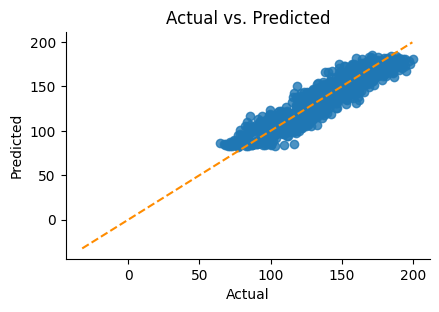

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


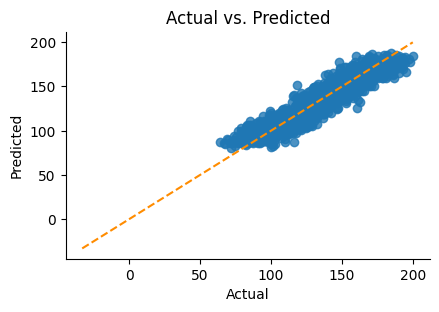

In [8]:
linear_assumption(base_model, X_train, y_train)
linear_assumption(pca_model, X_pca_train, y_train)

## Assumptions 2 : Normality of the Error Terms

In [9]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(6, 3))
    plt.title('Distribution of Residuals')
    sns.histplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.5179779958703243
Residuals are normally distributed


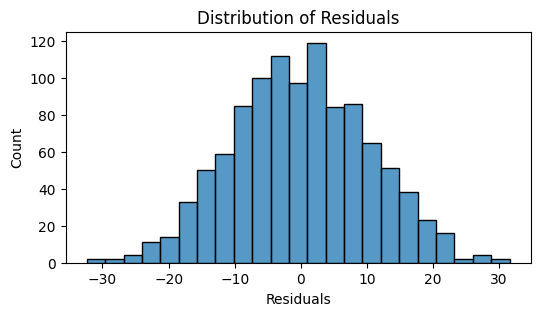


Assumption satisfied
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.1278630436184521
Residuals are normally distributed


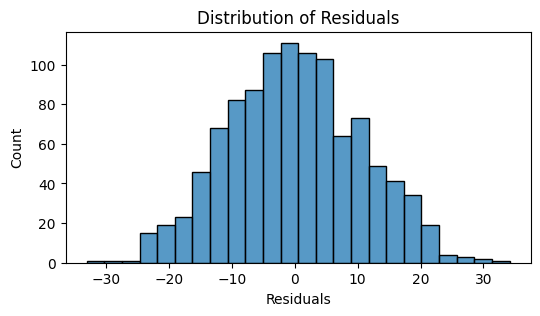


Assumption satisfied


In [10]:
normal_errors_assumption(base_model, X_train, y_train)
normal_errors_assumption(pca_model, X_pca_train, y_train)

## Assumptions 3 : No Multicollinearity among Predictors

In [15]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=False)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    # for idx, vif in enumerate(VIF):
    #     print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

Assumption 3: Little to no multicollinearity among predictors


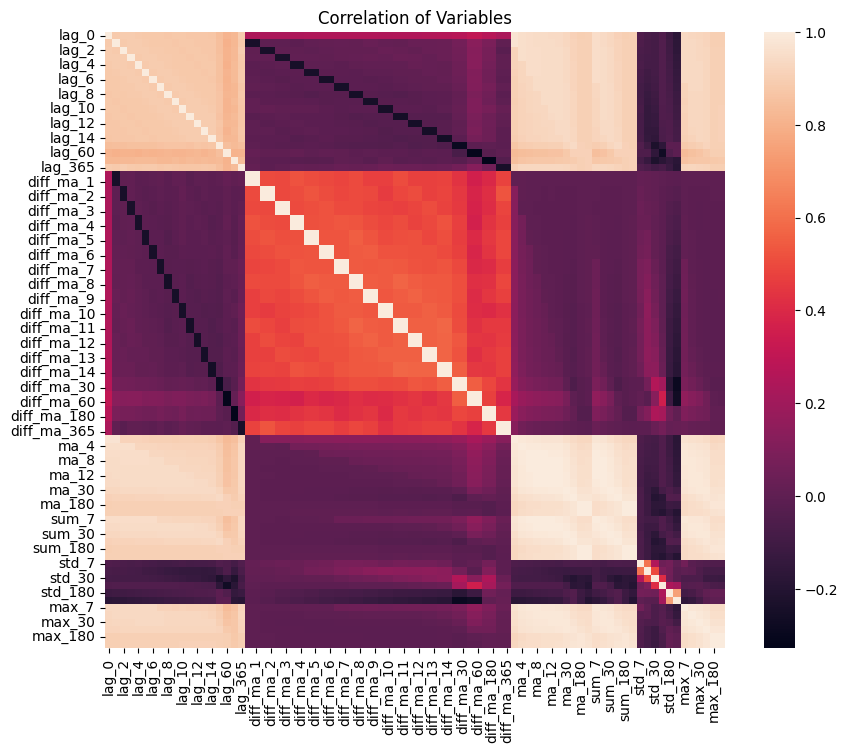

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------

84 cases of possible multicollinearity
83 cases of definite multicollinearity

Assumption not satisfied

Coefficient interpretability will be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)
Assumption 3: Little to no multicollinearity among predictors


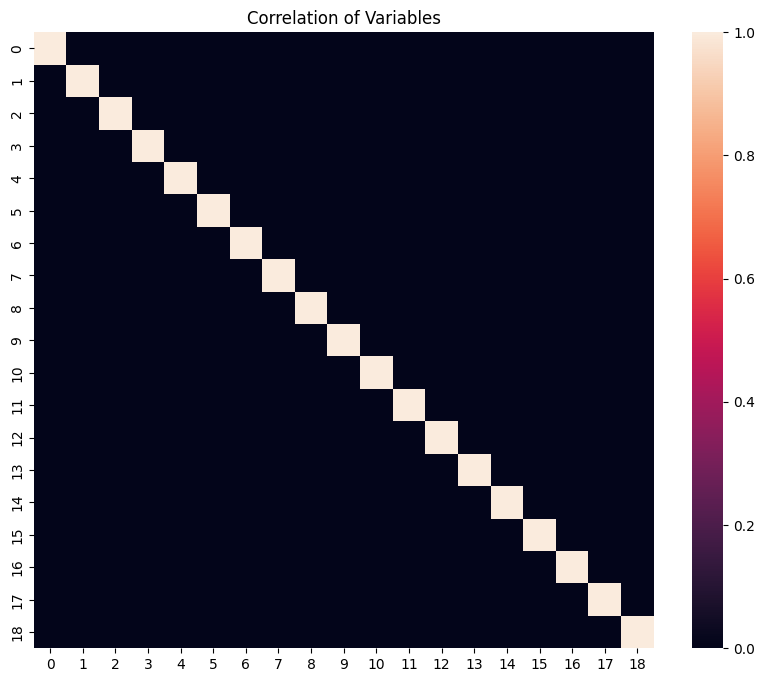

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied


In [16]:
multicollinearity_assumption(base_model, X_train, y_train, X_train.columns)
multicollinearity_assumption(pca_model, df_pca_train, y_train, df_pca_train.columns)

## Assumptions 4 : No Autocorrelation of the Error Terms

In [94]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('Performing Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [95]:
autocorrelation_assumption(base_model, X_train, y_train)
autocorrelation_assumption(pca_model, X_pca_train, y_train)

Assumption 4: No Autocorrelation
Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.8873830018131768
Little to no autocorrelation 

Assumption satisfied
Assumption 4: No Autocorrelation
Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.8389691691647427
Little to no autocorrelation 

Assumption satisfied


## Assumptions 5 : Homoscedasticity

In [96]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(6, 3))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


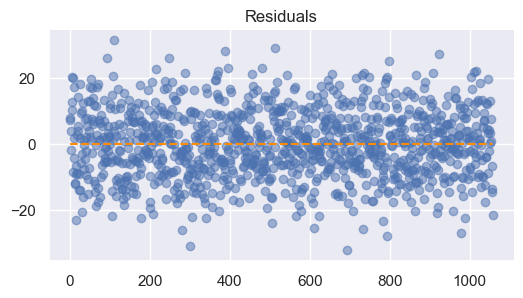

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


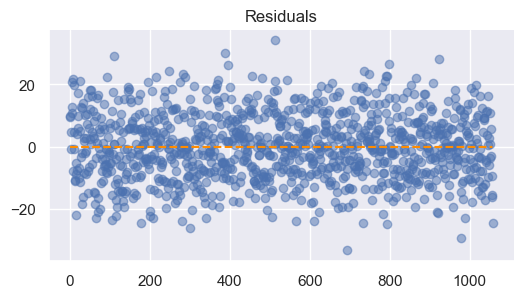

In [97]:
homoscedasticity_assumption(base_model, X_train, y_train)
homoscedasticity_assumption(pca_model, X_pca_train, y_train)

# test liner assumptions library

In [6]:
from utils.linear_assumptions import linear_regression_assumptions

Fitting linear regression

R^2: 0.8796258432660611 

Coefficients
-------------------------------------
Intercept: 49.36258717751883
X1: 0.004556886393024792
X2: 0.03158192473281612
X3: 0.010021100162214441
X4: 0.0003598671450064303
X5: -0.004541484404359275
X6: -0.0007894015627430096
X7: -0.02092866266309237
X8: -0.0035081479592382267
X9: 0.02047055612789523
X10: -0.0030358668302214752
X11: 0.0006305872721880101
X12: -0.0018343531222028558
X13: -0.014841845583235348
X14: -0.020237968133805517
X15: 0.01145881454593057
X16: -0.004292586210744798
X17: 0.010822552583619853
X18: 0.006010695064519803
X19: 0.03760802058437468
X20: -0.027025038339108354
X21: -0.0013512519169615322
X22: -0.005464213769228621
X23: -0.00027321068845895247
X24: 0.004197019248002198
X25: 0.0002098509623997824
X26: 0.009098370797341493
X27: 0.0004549185398645683
X28: 0.005346287955778128
X29: 0.0002673143977904857
X30: 0.025485549056112222
X31: 0.0012742774528303469
X32: 0.00806503435225453
X33: 0.00040325171761346

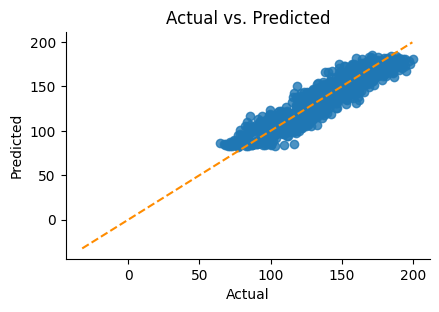

>>> Assumption 2: The error terms are normally distributed
Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.5179779958703243
Residuals are normally distributed


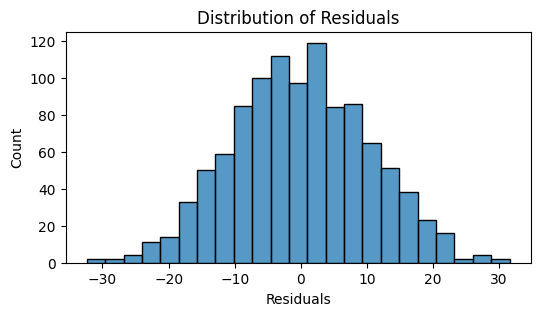

Assumption satisfied

>>> Assumption 3: Little to no multicollinearity among predictors


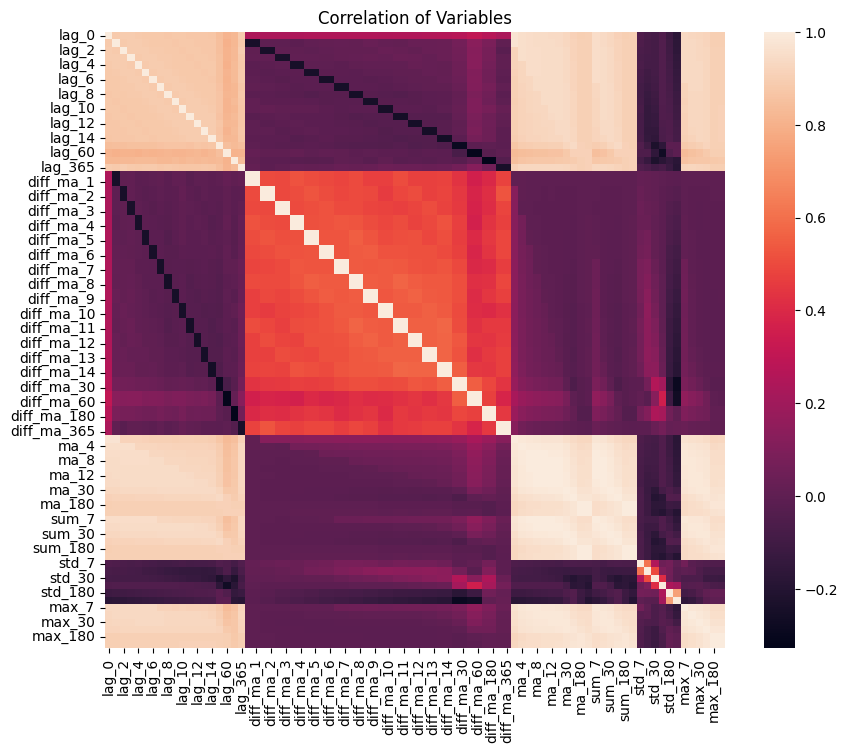

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------


c:\Users\panya\anaconda3\envs\eda\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


lag_0: inf
lag_1: inf
lag_2: inf
lag_3: inf
lag_4: inf
lag_5: inf
lag_6: inf
lag_7: inf
lag_8: inf
lag_9: inf
lag_10: inf
lag_11: inf
lag_12: inf
lag_13: inf
lag_14: inf
lag_30: inf
lag_60: inf
lag_180: inf
lag_365: inf
diff_1: inf
diff_ma_1: inf
diff_2: inf
diff_ma_2: inf
diff_3: inf
diff_ma_3: inf
diff_4: inf
diff_ma_4: inf
diff_5: inf
diff_ma_5: inf
diff_6: inf
diff_ma_6: inf
diff_7: inf
diff_ma_7: inf
diff_8: inf
diff_ma_8: inf
diff_9: inf
diff_ma_9: inf
diff_10: inf
diff_ma_10: inf
diff_11: inf
diff_ma_11: inf
diff_12: inf
diff_ma_12: inf
diff_13: inf
diff_ma_13: inf
diff_14: inf
diff_ma_14: inf
diff_30: inf
diff_ma_30: inf
diff_60: inf
diff_ma_60: inf
diff_180: inf
diff_ma_180: inf
diff_365: inf
diff_ma_365: inf
ma_2: inf
ma_4: inf
ma_6: inf
ma_8: inf
ma_10: inf
ma_12: inf
ma_14: inf
ma_30: inf
ma_60: inf
ma_180: inf
ma_365: inf
sum_7: inf
sum_14: inf
sum_30: inf
sum_60: inf
sum_180: inf
sum_365: inf
std_7: 46.502955915642055
std_14: 100.74726842159104
std_30: 147.33799317097228


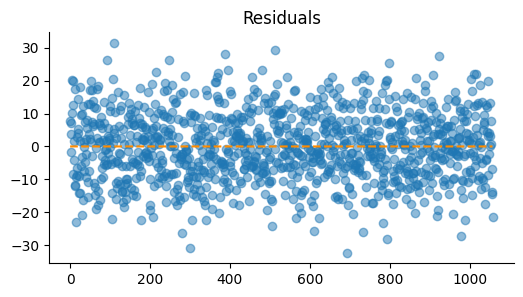

In [7]:
linear_regression_assumptions(X_train, y_train)